In [ ]:
%%configure
{
    "conf":{
        "spark.pyspark.virtualenv.enabled": "false"
    }
}

In [1]:
# Import local libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
import math

# Import GeoPandas
import geopandas as gpd

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import col, array, udf, monotonically_increasing_id, expr

# Import Apache Sedona
from sedona.register import SedonaRegistrator
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter as adp

## Define spark session if not defined yet
No need to define spark if run in an external cloud

In [2]:
try:
    spark
except NameError:
    spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()

23/04/06 01:37:22 WARN Utils: Your hostname, Kanchans-Laptop.local resolves to a loopback address: 127.0.0.1; using 192.168.1.13 instead (on interface en0)
23/04/06 01:37:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/opt/homebrew/Cellar/apache-spark/3.3.1/libexec/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/kanchan/.ivy2/cache
The jars for the packages stored in: /Users/kanchan/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-edf27831-b7c6-49f8-bcb8-d8b0f1f610e4;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.2.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.apache.sedona#sedona-core-3.0_2.12;1.2.0-incubating in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in central
	found org.apache.sedona#sedona-sql-3.0_2.12;1.2.0-incubating in central
	found org.datasyslab#geotools-wrapper;1.1.0-25.2 in central
:: resolution report :: resolve 148ms :: artifacts dl 5ms
	:: modules in use:
	org.apache.sedona#sedona-core-3.0_2.12;1.2.0-incubating from central in [default]
	o

23/04/06 01:37:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

def delete_path(sc, path):
    fs = (sc._jvm.org
          .apache.hadoop
          .fs.FileSystem
          .get(sc._jsc.hadoopConfiguration())
          )
    fs.delete(sc._jvm.org.apache.hadoop.fs.Path(path), True)

## Use the prefix in all your EMR path

If you use EMR, EMR requires that all paths must be relative. Please use the variable below as the prefix for all paths because it can automatically detect if you are in Wherobots environment or not.

In [4]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else ''

print(PATH_PREFIX)

/


## Load Airbnb Listing Data to Sedona

In [8]:
listings_df = spark.read.format("csv").option("header",False).load("s3a://wherobots-examples/data/airbnb_part.csv")
listings_df.createOrReplaceTempView("listings_df")
listings_df = spark.sql("select double(_c0) as longitude, double(_c1) as latitude from listings_df")
listings_df.show(5)

+------------------+------------------+
|         longitude|          latitude|
+------------------+------------------+
|         -97.75165|30.268690000000003|
|         -97.85608|          30.34998|
|-97.76619000000001|           30.2309|
|-97.74913000000001|          30.24648|
|         -97.74167|           30.2991|
+------------------+------------------+
only showing top 5 rows



In [9]:
## add id column and convert longitude and latitude into feature vectors
listings_df = listings_df.withColumn("id", monotonically_increasing_id())
listings_df = listings_df.withColumn("geometry", expr("ST_Point(double(longitude), double(latitude))"))
listings_df = listings_df.drop('latitude').drop('longitude')
listings_df.createOrReplaceTempView("listings_df")
listings_df.show(5)

+---+--------------------+
| id|            geometry|
+---+--------------------+
|  0|POINT (-97.75165 ...|
|  1|POINT (-97.85608 ...|
|  2|POINT (-97.766190...|
|  3|POINT (-97.749130...|
|  4|POINT (-97.74167 ...|
+---+--------------------+
only showing top 5 rows



## Perform DBSCAN Clustering
Cluster the points based on DBSCAN algorithm. For each point the returned DataFrame conatins the cluster labels with the column name component.

In [14]:
from lampy import DBSCAN
from lampy import SparkRegistration

SparkRegistration.set_spark_session(spark)

In [15]:
df_clusters = DBSCAN.fit(listings_df, geometry="geometry", epsilon=0.02, min_pts=4)
df_clusters.createOrReplaceTempView("df_clusters")
df_clusters.show()

+-----+---------+----------+
|point|component|core_point|
+-----+---------+----------+
|  356|        0|      true|
|  472|        0|      true|
|  338|        0|      true|
|  566|        0|      true|
|  103|        0|     false|
|  358|        0|     false|
|  293|        0|      true|
|  257|        0|      true|
|  506|        0|      true|
|  110|        0|      true|
|  446|        0|      true|
|  441|        0|      true|
|  551|        0|      true|
|   36|        0|      true|
|   26|        0|      true|
|  404|        0|      true|
|  403|        0|      true|
|  521|        0|      true|
|  474|        0|      true|
|  211|        0|      true|
+-----+---------+----------+
only showing top 20 rows



## Perfrom Post Processing on Clustered Data For Visualization

In [16]:
clustersDf = spark.sql('select a.id as id, a.geometry as geometry, b.component as label, b.core_point as core_point from listings_df a left outer join df_clusters b on a.id = b.point')
clustersDf.createOrReplaceTempView("clustersDf")
clustersDf.show(5)

+---+--------------------+-----+----------+
| id|            geometry|label|core_point|
+---+--------------------+-----+----------+
|  0|POINT (-97.75165 ...|    0|      true|
|  1|POINT (-97.85608 ...|    1|      true|
|  2|POINT (-97.766190...|    0|      true|
|  3|POINT (-97.749130...|    0|      true|
|  4|POINT (-97.74167 ...|    0|      true|
+---+--------------------+-----+----------+
only showing top 5 rows



## Labeling Noise Points with -1
Noise points are not under any cluster. Label them as -1

In [17]:
clustersDf = clustersDf.na.fill(value=-1,subset=["label"])
clustersDf = clustersDf.na.fill(value=False,subset=["core_point"])
clustersDf.show(5)

+---+--------------------+-----+----------+
| id|            geometry|label|core_point|
+---+--------------------+-----+----------+
|  0|POINT (-97.75165 ...|    0|      true|
|  1|POINT (-97.85608 ...|    1|      true|
|  2|POINT (-97.766190...|    0|      true|
|  3|POINT (-97.749130...|    0|      true|
|  4|POINT (-97.74167 ...|    0|      true|
+---+--------------------+-----+----------+
only showing top 5 rows



## Visualize the DBSCAN Clusters and Noises
label -1 indicates noise points

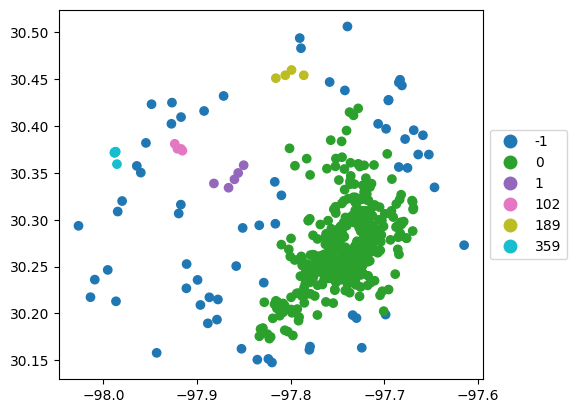

In [18]:
clustersGdf = gpd.GeoDataFrame(clustersDf.toPandas(), geometry = "geometry")
ax = clustersGdf.plot(column='label', categorical=True, aspect = 'equal', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})

In [ ]:
%matplot plt